
Summary Statistics for Overall:
  RISE_Score: mean=2.286, median=2.292, std=0.490, min=1.000, max=3.625, count=34862
  Physical_Score: mean=2.230, median=2.333, std=0.721, min=1.000, max=5.000, count=34449
  Information_Score: mean=2.059, median=2.000, std=0.609, min=1.000, max=4.000, count=33384
  Cognitive_Score: mean=2.204, median=2.333, std=1.055, min=1.000, max=4.500, count=34862
  Social_Score: mean=2.744, median=2.750, std=0.780, min=1.000, max=5.000, count=34517
  Prepare_Score: mean=2.063, median=2.333, std=0.617, min=1.000, max=4.000, count=34484
  Absorb_Score: mean=1.620, median=1.750, std=0.571, min=1.000, max=4.000, count=34660
  Recover_Score: mean=2.573, median=2.500, std=0.597, min=1.000, max=5.000, count=34484
  Adapt_Score: mean=2.918, median=2.750, std=0.756, min=1.000, max=5.000, count=34862

Summary Statistics for Portfolio Stocks:
  RISE_Score: mean=2.371, median=2.260, std=0.694, min=1.000, max=3.625, count=50
  Physical_Score: mean=2.316, median=2.250, std=0.7

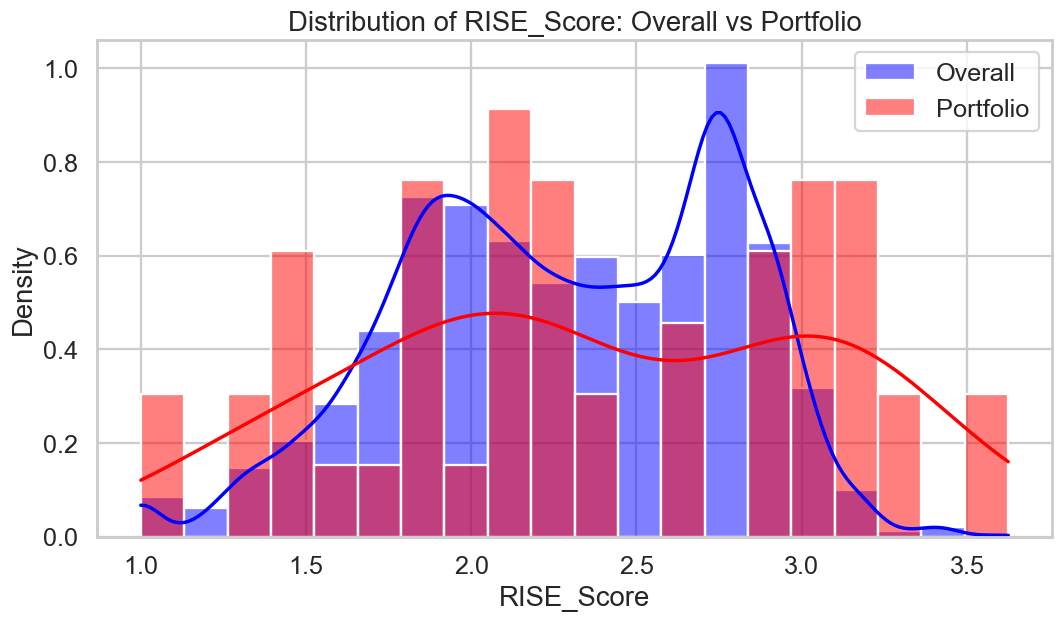

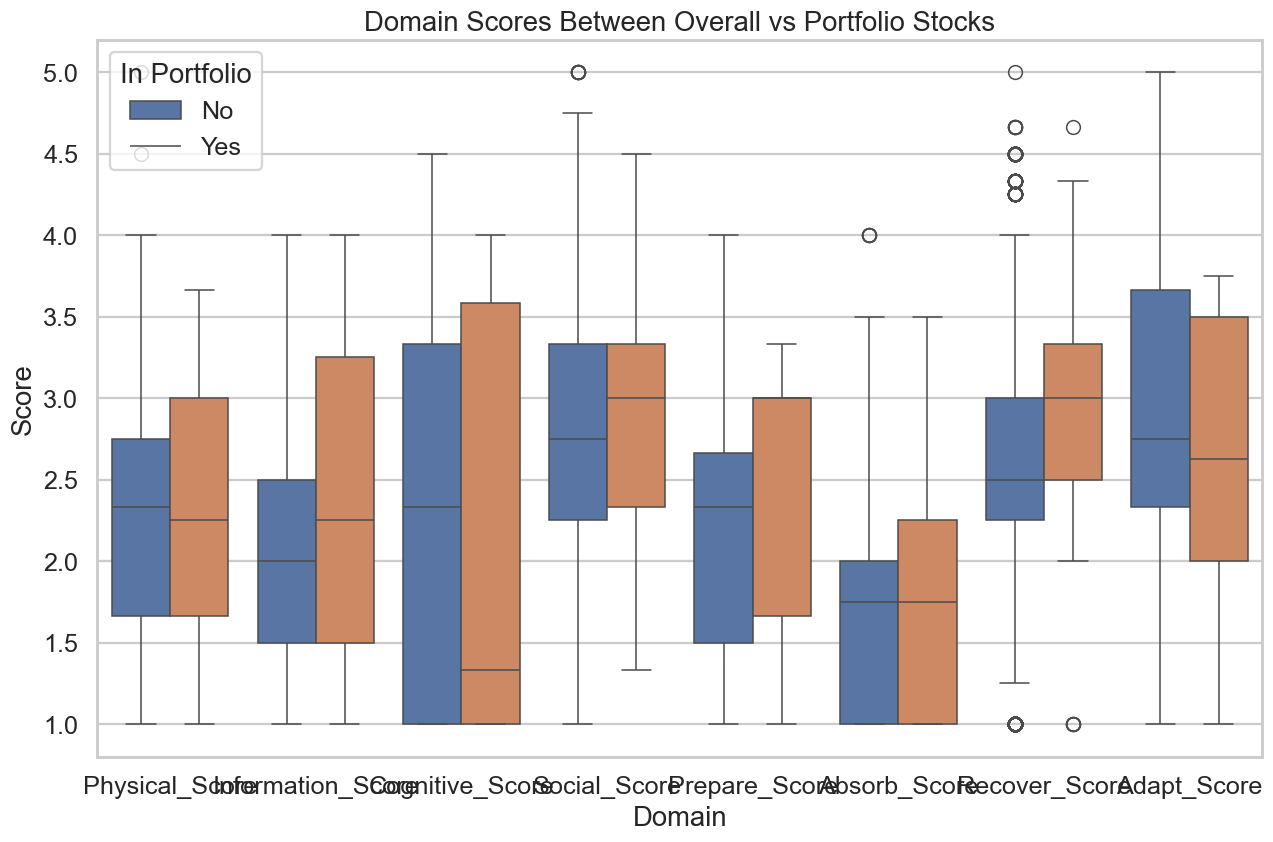

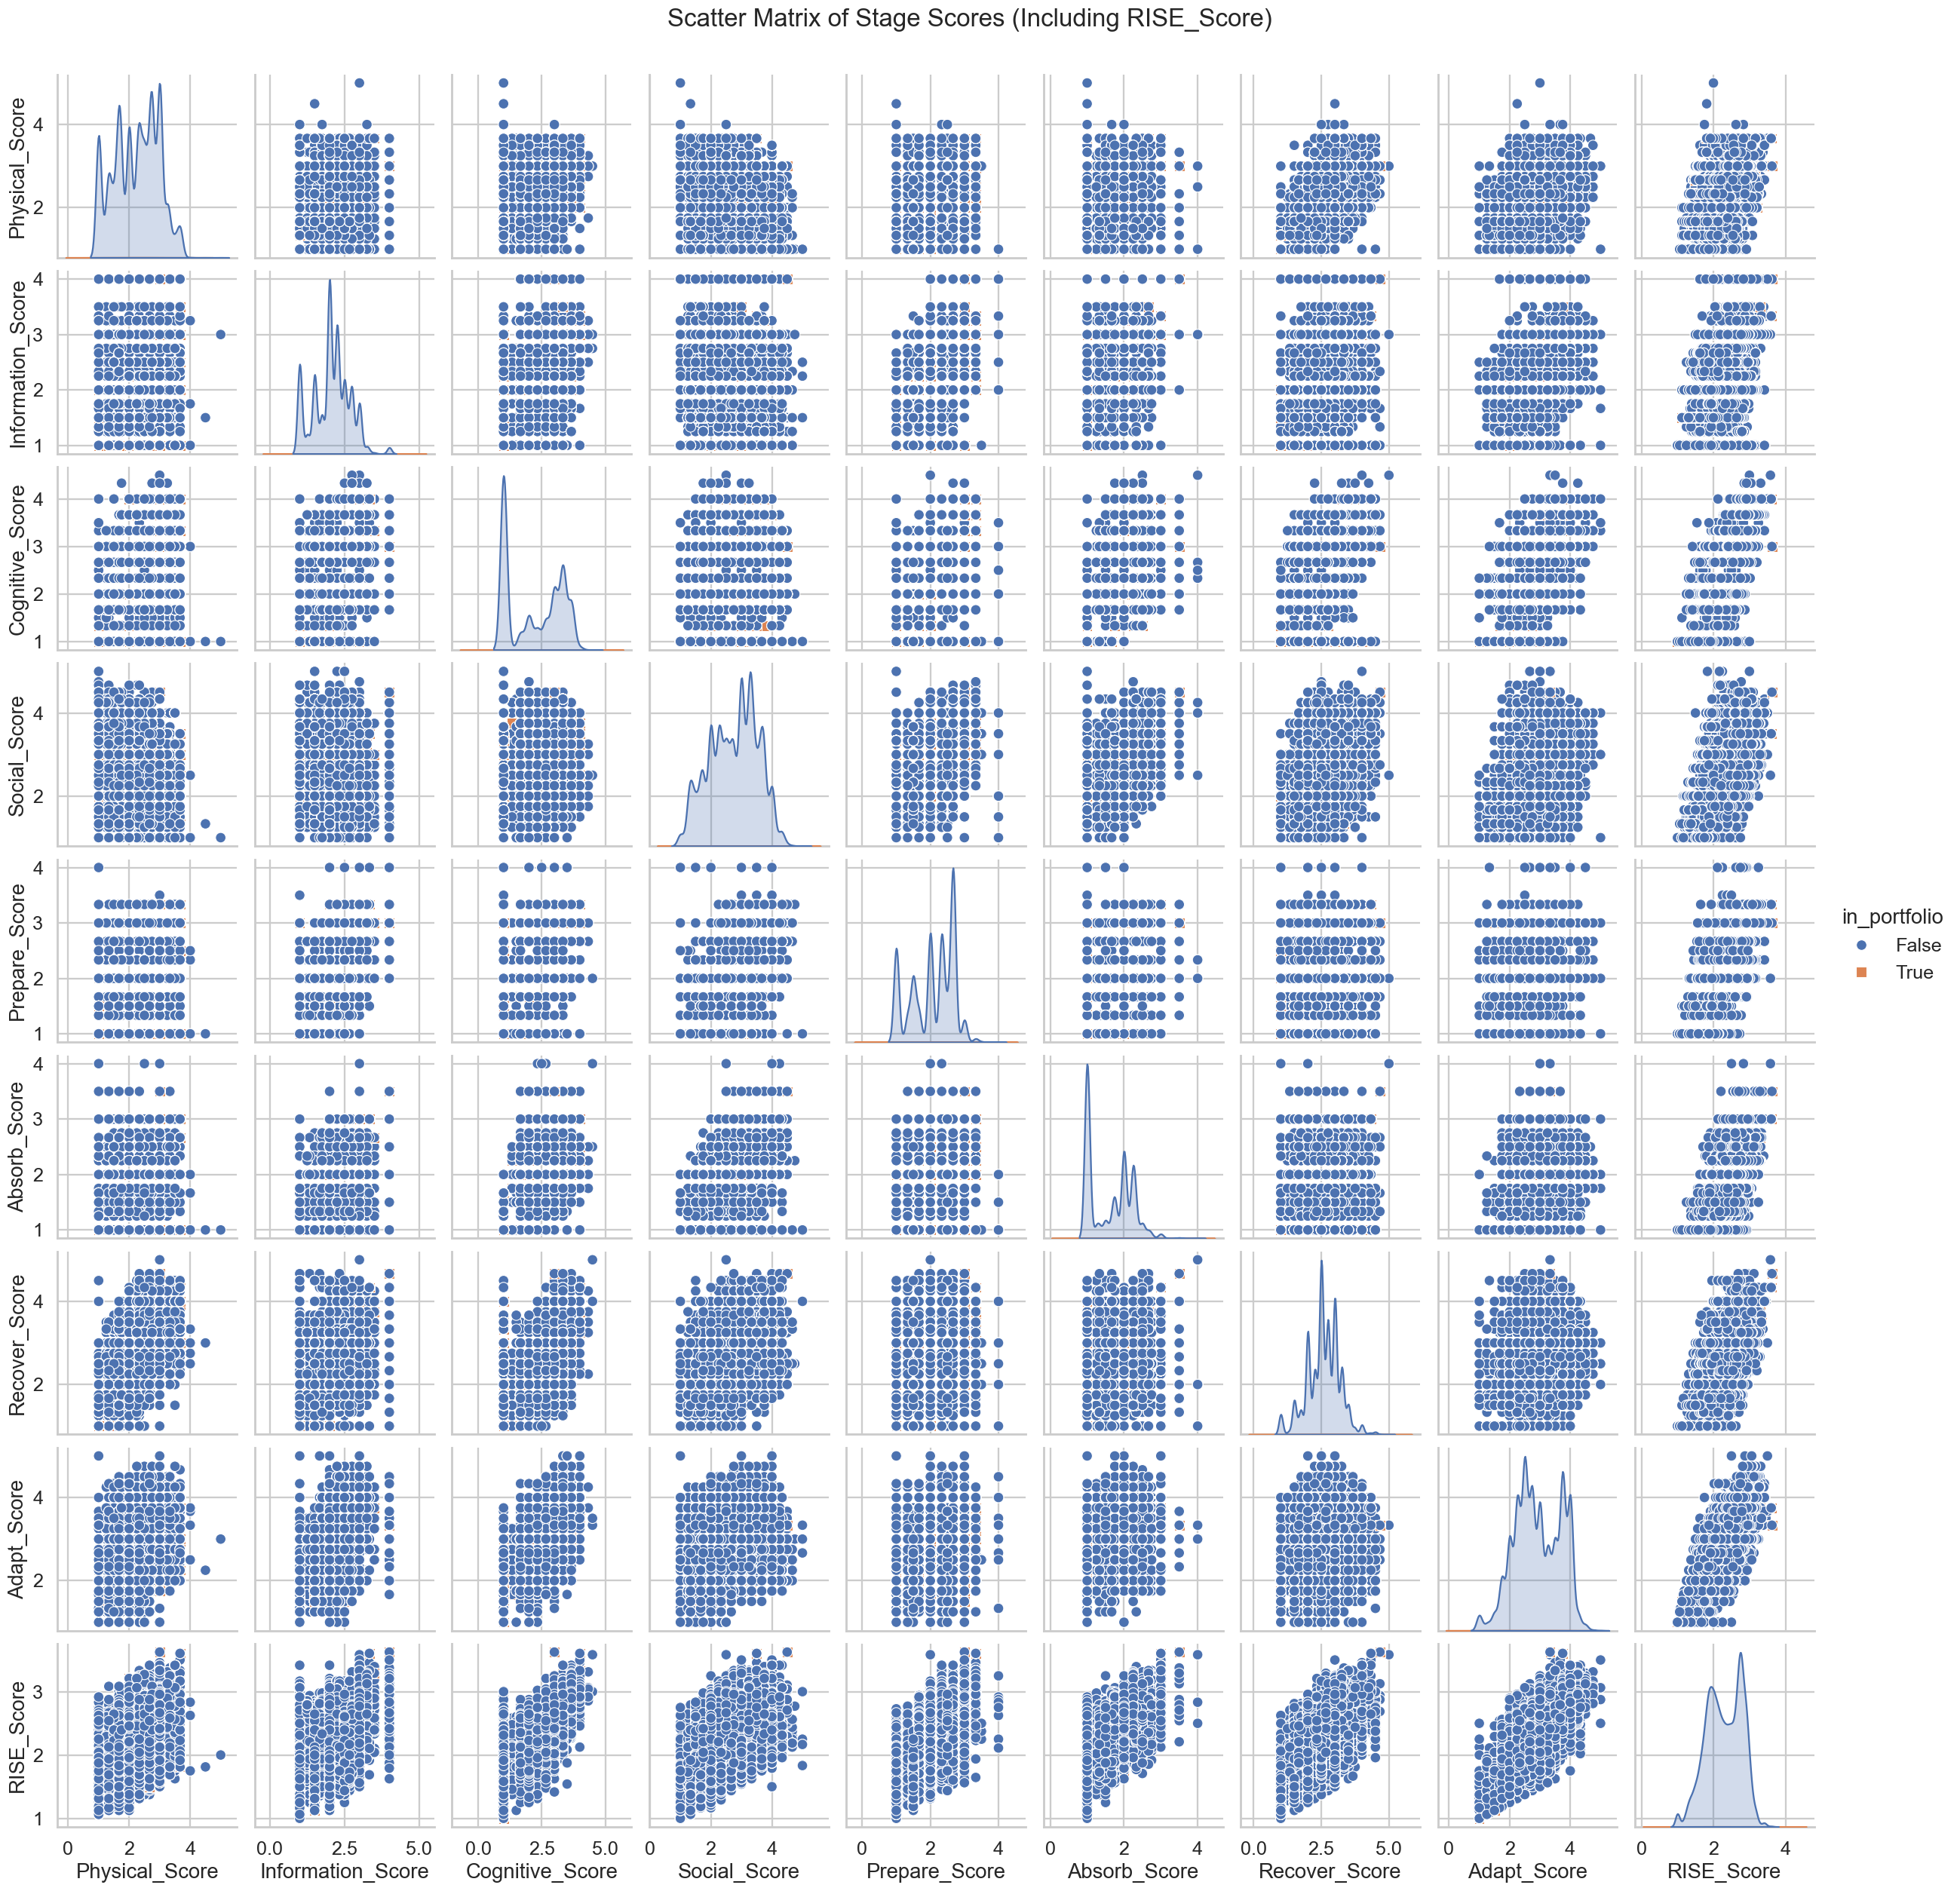


Average Domain Scores by Group:
        Group  Physical_Score  Information_Score  Cognitive_Score  Social_Score  Prepare_Score  Absorb_Score  Recover_Score  Adapt_Score
Non-Portfolio        2.229731           2.058345         2.204652      2.743982       2.062219      1.620381       2.572124     2.918886
    Portfolio        2.316327           2.267007         2.046667      2.858844       2.394558      1.688776       2.843537     2.635000

Dashboard summary saved to: C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff\event=2008\20250609\stage05a\Stage22_PortfolioSummary.csv


In [ ]:
#!/usr/bin/env python
"""
Stage 22: Portfolio Comparison Dashboard

This stage takes a small portfolio of stocks (tickers) and compares their performance to the rest of the sample.
It loads the outputs from earlier stages (e.g., Stage 5A: Quintiles and Scores),
computes summary statistics (such as mean, median, standard deviation for RISE_Score and domain scores),
and produces visualizations to compare how the portfolio stocks perform across domains and stages.
"""

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Configuration (adjust as needed)
# -------------------------------
# Set the event year and run date (could also be grabbed from environment)
SWAN_YEAR = os.getenv("SWAN_YEAR", "2008")
RUN_DATE  = os.getenv("RUN_DATE", "20250609")

# Define the output root directory (as used in previous stages)
# For example, if outputs are saved in the "outputs_rff" folder:
OUTPUT_ROOT = Path("C:/Users/Jason Pohl/OneDrive - Bond University/PhD/rff/outputs_rff")

# Construct the path to the Stage 5A output, which contains the Quintiles and Scores.
# Adjust the folder structure if needed.
stage05a_dir = OUTPUT_ROOT / f"event={SWAN_YEAR}" / RUN_DATE / "stage05a"
scores_csv   = stage05a_dir / "Stage5A_QuintilesAndScores.csv"

if not scores_csv.is_file():
    raise FileNotFoundError(f"Stage 5A file not found at {scores_csv}")

# -------------------------------
# Load data from Stage 5A  
# -------------------------------
df = pd.read_csv(scores_csv)

# Ensure correct data types
if "Year" in df.columns:
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    
# Portfolio tickers: list of stock symbols for your portfolio (tickets)
portfolio_tickers = ["A11", "RC1", "BHPKMC", "XYZ", "ABC"]  # replace with your actual tickers

# Create a new column to mark if the stock is in the portfolio
df["in_portfolio"] = df["Symbol"].isin(portfolio_tickers)

# -------------------------------
# Compute Summary Statistics
# -------------------------------
# For overall sample and portfolio stocks, compute statistics for RISE_Score.
score_cols = ["RISE_Score"]
# Additionally, assume domain scores are in columns like 'Physical_Score', 'Information_Score',
# 'Cognitive_Score', 'Social_Score'. Adjust if your column names differ.
domain_cols = [col for col in df.columns if col.endswith("_Score") and col != "RISE_Score"]

def summarize_stats(dataframe, group_name="Overall"):
    summary = {}
    for col in score_cols + domain_cols:
        summary[col] = {
            "mean": dataframe[col].mean(),
            "median": dataframe[col].median(),
            "std": dataframe[col].std(),
            "min": dataframe[col].min(),
            "max": dataframe[col].max(),
            "count": dataframe[col].count()
        }
    print(f"\nSummary Statistics for {group_name}:")
    for col, stats in summary.items():
        print(f"  {col}: mean={stats['mean']:.3f}, median={stats['median']:.3f}, std={stats['std']:.3f}, min={stats['min']:.3f}, max={stats['max']:.3f}, count={stats['count']}")
    return summary

# Summary stats for overall sample
overall_stats = summarize_stats(df, "Overall")

# Summary stats for portfolio stocks
portfolio_df = df[df["in_portfolio"]]
portfolio_stats = summarize_stats(portfolio_df, "Portfolio Stocks")

# -------------------------------
# Visualizations
# -------------------------------
sns.set(style="whitegrid", context="talk")

# 1. Histogram of RISE Score for overall sample vs portfolio stocks
plt.figure(figsize=(10, 6))
sns.histplot(df["RISE_Score"].dropna(), bins=20, color="blue", label="Overall", kde=True, stat="density")
sns.histplot(portfolio_df["RISE_Score"].dropna(), bins=20, color="red", label="Portfolio", kde=True, stat="density")
plt.title("Distribution of RISE_Score: Overall vs Portfolio")
plt.xlabel("RISE_Score")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Boxplots of Domain Scores grouped by Portfolio membership.
if domain_cols:
    plt.figure(figsize=(12, 8))
    domain_data = pd.melt(df, id_vars=["Symbol", "in_portfolio"], value_vars=domain_cols,
                          var_name="Domain", value_name="Score")
    sns.boxplot(x="Domain", y="Score", hue="in_portfolio", data=domain_data)
    plt.title("Domain Scores Between Overall vs Portfolio Stocks")
    plt.xlabel("Domain")
    plt.ylabel("Score")
    plt.legend(title="In Portfolio", labels=["No", "Yes"])
    plt.tight_layout()
    plt.show()

# 3. Scatter plot matrix for stage scores and RISE_Score comparing portfolio vs overall
stage_score_cols = [col for col in df.columns if col.endswith("_Score")]  # including RISE_Score and others
if stage_score_cols:
    sns.pairplot(df[stage_score_cols + ["in_portfolio"]], hue="in_portfolio", diag_kind="kde", markers=["o", "s"])
    plt.suptitle("Scatter Matrix of Stage Scores (Including RISE_Score)", y=1.02)
    plt.show()

# -------------------------------
# Group-level Comparison by Domain 
# -------------------------------
# Compute average scores for portfolio and non-portfolio groups by domain.
grouped = df.groupby("in_portfolio")[domain_cols].mean().reset_index()
group_label = {True: "Portfolio", False: "Non-Portfolio"}
grouped["Group"] = grouped["in_portfolio"].apply(lambda x: group_label[x])
print("\nAverage Domain Scores by Group:")
print(grouped[["Group"] + domain_cols].to_string(index=False))

# -------------------------------
# Save dashboard summary to CSV
# -------------------------------
output_summary = stage05a_dir / "Stage22_PortfolioSummary.csv"
df.to_csv(output_summary, index=False)
print(f"\nDashboard summary saved to: {output_summary}")

if __name__ == "__main__":
    pass
